<a href="https://colab.research.google.com/github/itskov/WaferDefects/blob/main/WaferDefects_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wafer Defects Analysis
By Eyal Itskovits

In this notebook I will presents my attempts at finiding defects on Wafers.
Obviously, the approach need to be taken given the amount of data given is an unsupervised one. 

## _**Initialization**_

Run this code the initialize the environment:

In [24]:
!rm -rf WaferDefects
!git clone https://github.com/itskov/WaferDefects.git

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys

# Reseting visualization configuration.
matplotlib.rc_file_defaults()

sys.path.append('./WaferDefects')

# For reproducibility.
np.random.seed(1)

from WDPreprocessing import WDPreprocessing
# Preprocessing.
prp = WDPreprocessing('./WaferDefects/raw_data/defective_examples', './WaferDefects/raw_data/non_defective_examples')



Cloning into 'WaferDefects'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 72 (delta 31), reused 56 (delta 18), pack-reused 0
Unpacking objects: 100% (72/72), done.


## _Image Alignment_ ##

First thing I did was to align the _inspected_ to the _reference_ images. This was done by cross-correlation between the two images. In the figures below you can see the portion of the image used to the cross correlation (purple rectangle) and the nessecary translation the was performed on each image (yellow rectangle). I assumed that there was no rotational displacment.


Orig top left: 100, 50
Cross-corr top left: 104 27 
Orig top left: 100, 50
Cross-corr top left: 95 44 
Orig top left: 100, 50
Cross-corr top left: 79 54 


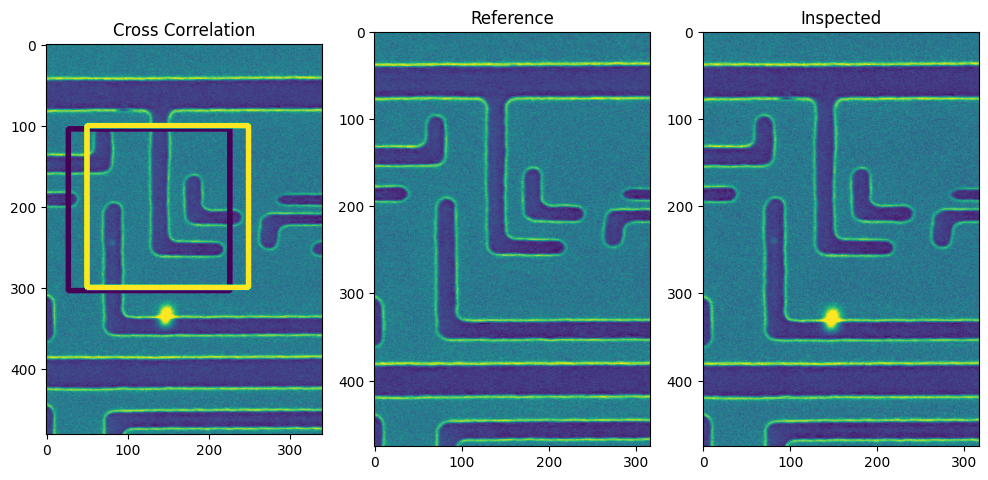

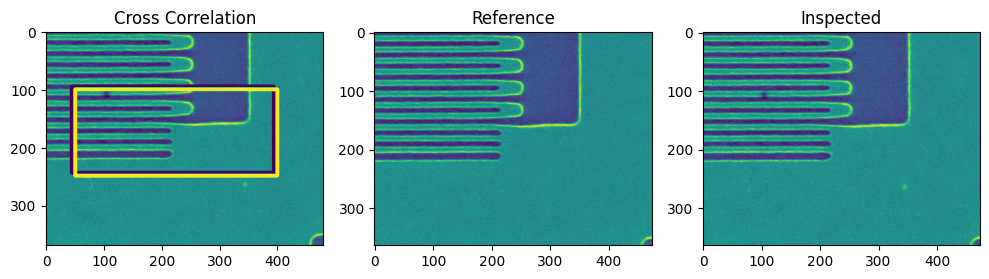

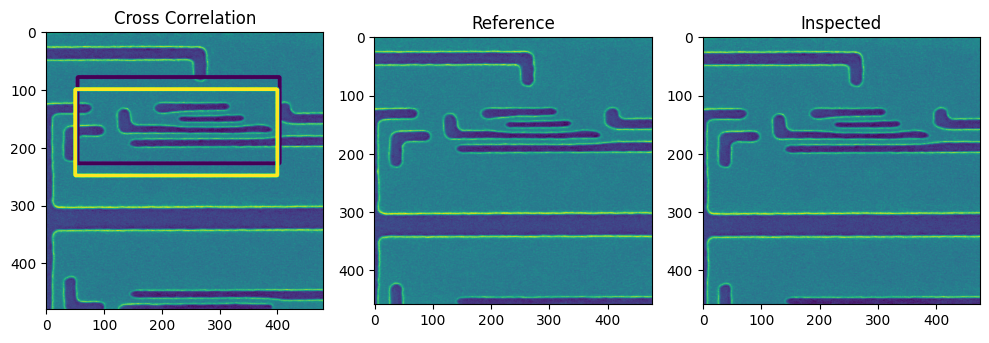

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

inspected_image = cv2.imread('/content/WaferDefects/raw_data/defective_examples/case1_inspected_image.tif', 0)
reference_image = cv2.imread('/content/WaferDefects/raw_data/defective_examples/case1_reference_image.tif', 0)

# Alignin the image using cross-correlation.
WDPreprocessing.align_images(inspected_image, 
                             reference_image,
                             range(100, 300), 
                             range(50, 250), 
                             verbose=True, plot=True);


inspected_image = cv2.imread('/content/WaferDefects/raw_data/defective_examples/case2_inspected_image.tif', 0)
reference_image = cv2.imread('/content/WaferDefects/raw_data/defective_examples/case2_reference_image.tif', 0)

# Alignin the image using cross-correlation.
WDPreprocessing.align_images(inspected_image, 
                             reference_image,
                             range(100, 250), 
                             range(50, 400), 
                             verbose=True, plot=True);


inspected_image = cv2.imread('/content/WaferDefects/raw_data/non_defective_examples/case3_inspected_image.tif', 0)
reference_image = cv2.imread('/content/WaferDefects/raw_data/non_defective_examples/case3_reference_image.tif', 0)

# Alignin the image using cross-correlation.
WDPreprocessing.align_images(inspected_image, 
                             reference_image,
                             range(100, 250), 
                             range(50, 400), 
                             verbose=True, plot=True);





## _The straight-forward way: looking on the differences between aligned images_ ##

Looking at the difference between the the inspected and the reference images is one way to track defects. However, we need to set a cutoff for the difference to differentiate defects from noise. To do that, I looked at the distribution of the differences between the _reference_ and the _inspected_ wafers in the "case3" (the non-defective one). The cutoff that was chosen is the 0.98 quantile of this distribution.

0.99 quantile: 38


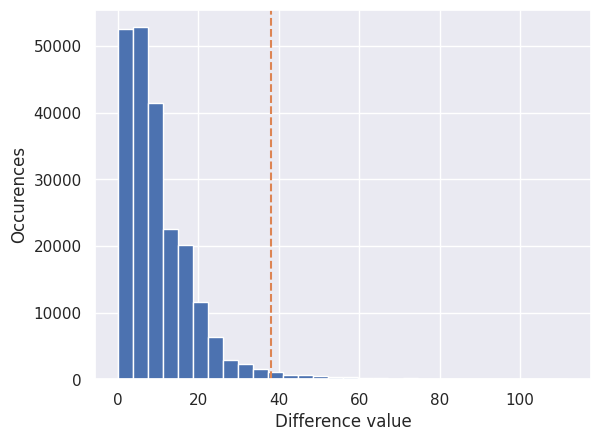

In [109]:
inspected = (cv2.imread(prp.samples_dict['case3'].inspected, 0))
reference = (cv2.imread(prp.samples_dict['case3'].reference, 0))

sns.set()
dif = np.ravel(np.abs(np.int16(reference) - inspected));
#dif = np.ravel(np.abs(np.int16(inspected) - reference) / (reference + 10**-6))
#dif[dif > 1] = 1

quant = np.quantile(dif, 0.98)
print('0.99 quantile: %d' % (quant,))
plt.hist(dif, 30)
prev_ylim = plt.ylim()
plt.plot([quant, quant],[0, prev_ylim[1]],'--')
plt.ylim(prev_ylim)
plt.xlabel('Difference value')
plt.ylabel('Occurences')
matplotlib.rc_file_defaults()

This will leave 1/50 of the pixel marked as defects. Since the fraction of defective pixels is lower than this, this approach will yield a lot of false-positive. We will deal with them later. First let's examine this simple approach of substraction and applying a cutoff:

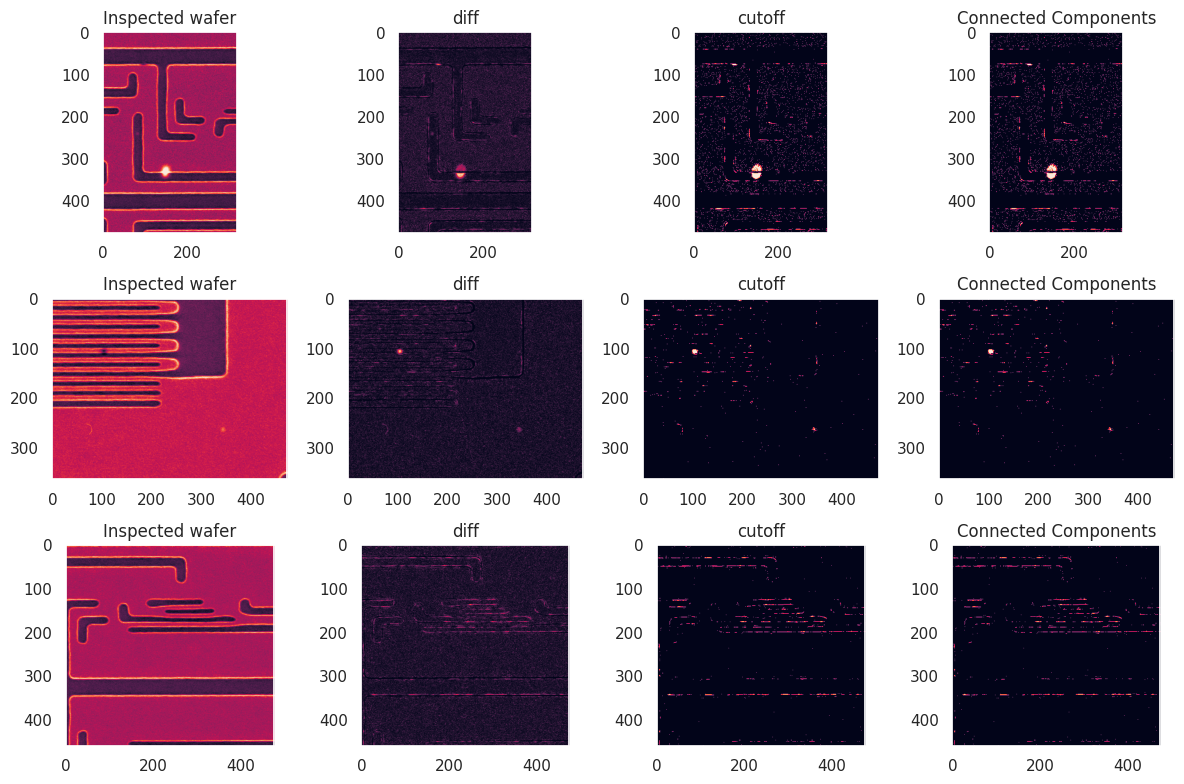

In [111]:
def create_diff_map(case, cutoff):
  inspected = (cv2.imread(prp.samples_dict[case][0], 0))
  reference = (cv2.imread(prp.samples_dict[case][1], 0))

  # Saturating the high intensity pixel (this will be discussed later) 
  inspected[inspected > 165] = 165
  reference[reference > 165] = 165
  
  dif_img = np.abs(np.int16(inspected) - reference)
  #dif_img = np.abs(np.int16(inspected) - reference) / (reference + 10**-6)
  dif_cutoff = np.uint8(dif_img > cutoff)

  num_labels, labels_im = cv2.connectedComponents(np.uint8(dif_cutoff))

  return (dif_img, dif_cutoff, labels_im, num_labels)


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

sns.set()

sub_count = 1
for case in ['case1', 'case2','case3']:
  [dif_img, dif_cutoff, connected_com, num_labels] = create_diff_map(case, quant)

  plt.subplot(3, 4, sub_count)
  plt.imshow(cv2.imread(prp.samples_dict[case].inspected, 0))
  plt.title('Inspected wafer')
  plt.grid(False)
  sub_count += 1

  plt.subplot(3, 4, sub_count)
  plt.imshow(dif_img)
  plt.grid(False)
  plt.title('diff')
  sub_count += 1

  plt.subplot(3, 4, sub_count)
  plt.imshow(np.uint8(dif_cutoff) * 255)
  plt.grid(False)
  plt.title('cutoff')
  sub_count += 1

  plt.subplot(3, 4, sub_count)
  plt.imshow(np.uint8(connected_com > 0))
  plt.grid(False)
  plt.title('Connected Components')
  sub_count += 1





plt.tight_layout()
matplotlib.rc_file_defaults()




As expected. Though this simple approach catches the marked defects, it also catches tones of false-positives. Thus, from this point on we will treat this pixels only as _candidate_ pixels for defects. 

## _Reducing the color space: Gaussian Mixtures Model_ ##

<p>
Examining the wafer images, it is clear that the color in the image does not span the entire uint8 range (0-255). There is clearly 3 principle colors in the data.
</p>

<p>
To verify this I looked on the distribution of the pixel intensity. It is appearant that pixels can be modeled by a mixture of 3 gaussians that correspond to: tunnel color (dark, blacking),  background (grey-sh) and tunnel border (broad white).
</p>




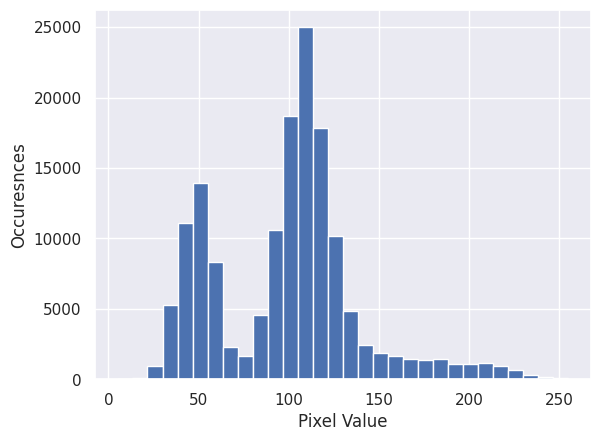

In [36]:
sns.set()
img = cv2.imread(prp.samples_dict['case1'].reference, 0)
plt.hist(np.ravel(img), 30)
plt.xlabel('Pixel Value')
plt.ylabel('Occuresnces')
matplotlib.rc_file_defaults()


<p>Thus, we can reduce the number of "colors" in our wafers to a space of 3. We can know use the EM algorithm (implemented in the sklearn) to learn the Gaussian Mixtures parameters ($\{{\mu}\}_0^2$, $\{{\sigma}\}_0^2$ and gaussian weight $\{{w}\}_0^2$) and perform the following steps:

- For each pixel we can decide to which "color" (out of the 3) it belongs.
- We can estimate the gaussian parameters of each "color".
- Using the above two, we can decide for each pixel how certain we are that it actually belong to this "color".</p>

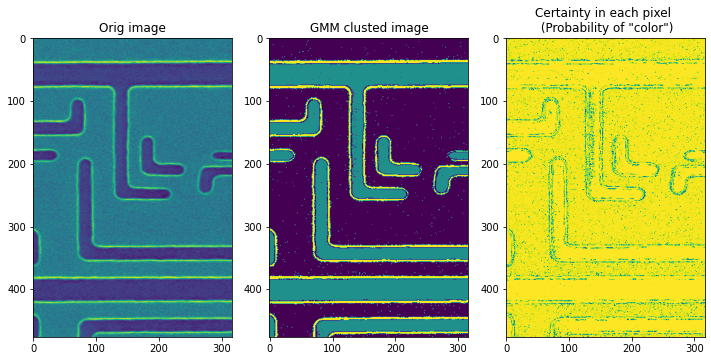

In [7]:
from WDGmm import WDGmm

gmm = WDGmm()
gmm.train_gmm('case1', prp)
[color_labels, color_probs] =  gmm.predict_gmm('case1', prp, True)

orig_img = cv2.imread(prp.samples_dict['case1'].reference, 0)

plt.rcParams['figure.figsize'] = [10, 6]



plt.subplot(1, 3, 1)
plt.imshow(orig_img)
plt.title('Orig image')

plt.subplot(1, 3, 2)
plt.imshow(color_labels)
plt.title('GMM clusted image')
plt.subplot(1, 3, 3)
plt.imshow(color_probs)
plt.title('Certainty in each pixel \n (Probability of "color")')
#plt.colorbar()

plt.tight_layout()



<p>One can appreciate that while the GMM-based color-clustering reduces the color space, there is still quite a lot of uncertainty around the edges of the wafer (the background is uniformly set to a single "color" with high certainty). </p>

## Why reducing the color space is a good idea? ##

Later on I am going to learn a probablistic distribution of a pixel given its vicinity in the reference image. Learning a discrete probablistic distribution over 255 values requires data I don't have. On the contrary, learning a distrubtion with a support of 3 values is much easier and doesn't require a lot of data.


## _Learning the distribution of inspected pixel value given its vicinity in the reference wafer_ ##



<p>From the above results it is clear that around the edges one can expect relatively frequeny high differences between inspected and reference wafers. I wanted to remove the false positives that are originated from those cases. To do this, I estimated the probability disitrubion over the pixels color value, given the neighbouring pixels in the reference wafers. That is, <p>

<p>
P(Pixel_value | Vicinity_In_Reference)
</p>

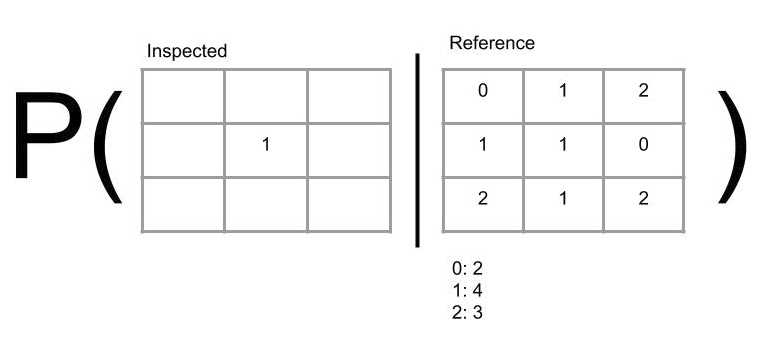


<p>
To be more precise, I learned a distribution of the value of pixel given the number of pixel from each "principle color". </p>
<p>
To do this I went over 'case3' (no defects) with a running kernel of 3x3. Each time I "recorded" the value of the "colors" in this small window of the reference, together with the value in the middle of the kernel in the inspected wafer. 
</p>



In [112]:
from WDProbModel import WDProbModel

[ref3Labels, _] = gmm.predict_gmm('case3', prp, True)
[insp3Labels, _] = gmm.predict_gmm('case3', prp,  False)

# 3 stands for the support of the color space: 3 possible values.
prob_model = WDProbModel(3)
# I deliberately did not go over the entirely of 'case3'. Adding too-much 
# "background" reduces the estimated probabilities around channels.
prob_model.add_data(ref3Labels, insp3Labels)

# This may seem as cheating. But in my opinion it is not. I will discuss this in the discusison.
# Nevertheless, it doesnt make a lot difference, and can be commented out:
ADD_ADDITIONAL_REGIONS_TO_PROB_MODEL = True
if ADD_ADDITIONAL_REGIONS_TO_PROB_MODEL:
  [ref1Labels, _] = gmm.predict_gmm('case1', prp, True)
  [insp1Labels, _] = gmm.predict_gmm('case1', prp,  False)
  [ref2Labels, _] = gmm.predict_gmm('case2', prp, True)
  [insp2Labels, _] = gmm.predict_gmm('case2', prp,  False)


  prob_model.add_data(ref1Labels[400:, :], insp1Labels[400:,])
  prob_model.add_data(ref2Labels[120:220, :], insp2Labels[120:220,])

##_Tying everything together: the proposed approach_##

I propose the following algorithm:
- Detect candiate pixels using a simple deduction of pixels values abs(inspected - observed).
- Use GMM-based clustering to move to a small color-space or 3.
- See for which of the _candidate_ pixels the value of the pixels is *not* probably given the reference (using the estimated reference->inspected distribution).
- Do the above while ignoring pixels for which there is an uncertaintly regarding their "color" value in both the _reference_ and _inspected_ wafer.

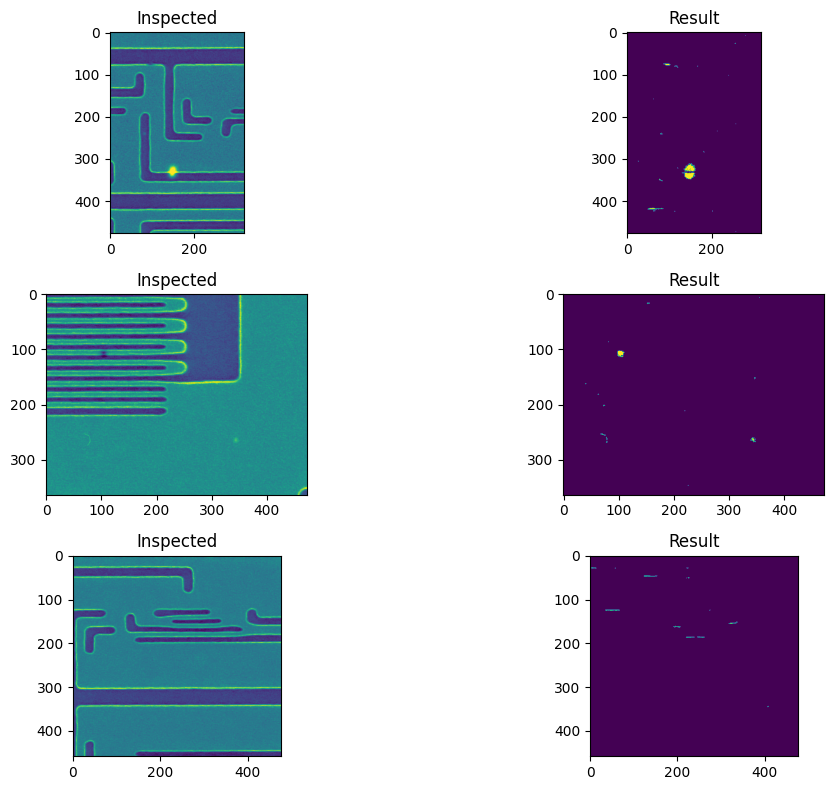

In [127]:
def find_defects(case, prp,  gmm_model, prob_model):
  reference_labels, reference_prob = gmm_model.predict_gmm(case, prp, True)
  inspected_labels, inspected_prob = gmm_model.predict_gmm(case, prp, False)

  # Mask of pixels we are "certain" of their new color assignment
  PROB_CUTOFF = 0.95
  certain_pixels = np.bitwise_and(reference_prob > PROB_CUTOFF, 
                                  inspected_prob > PROB_CUTOFF)

  # Getting the "Null-Hypothesis" probabiliy of inspected pixels values
  # (Given their vicinity in the reference)
  PVAL_CUTOFF = 0.02
  pvals = prob_model.get_image_probability(reference_labels, inspected_labels)
  not_likely_H0_pixels = pvals < PVAL_CUTOFF

  # Merging the two together
  potential_defects = np.bitwise_and(certain_pixels[1:-1, 1:-1], not_likely_H0_pixels)

  # Getting the candidates arising from a simple diff between the reference
  # and the expected
  DIFF_CUTOFF = 35
  (_, dif_cutoff, labels_im, num_labels) = create_diff_map(case, DIFF_CUTOFF)

  # Now merging this candidates with the our prob model
  final_cands = np.bitwise_and(dif_cutoff[1:-1, 1:-1], potential_defects)

  # Using the Connected regions map to create the result
  for i in range(1, num_labels):
    current_region = labels_im == i
    current_region = current_region[1:-1, 1:-1]

    # Removing the connected region if it does not
    # overlap with a probable candidate.
    if not np.any(np.bitwise_and(current_region, final_cands)):
      labels_im[labels_im == i] = 0
    
  labels_im[labels_im > 0] = 1

  #labels_im = cv2.erode(np.uint8(labels_im),(1,1),iterations = 1)
  #labels_im = cv2.dilate(np.uint8(labels_im),(2,2),iterations = 1)
  return labels_im


res1 = find_defects('case1', prp, gmm, prob_model)
res2 = find_defects('case2', prp, gmm, prob_model)
res3 = find_defects('case3', prp, gmm, prob_model)

# Plotting the results
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

for i, res in enumerate([res1, res2, res3]):
  plt.subplot(3,2, i*2 + 1)
  plt.title('Inspected')
  plt.imshow(cv2.imread(prp.samples_dict['case' + str(i + 1)].inspected, 0))
  plt.subplot(3,2, i*2 + 2)
  plt.imshow(res)
  plt.title('Result')

plt.tight_layout()





# Discussion

<p>
**False positives**<br>
I did not manage to get rid of all the false-positives. This can be be achieved by modifying the cut-off parameters for each wafer type. While this is not entirely unresenable, I chose not to do it and show the result for the same set of parameters.
</p>
<br>
<p>
**Things I would have done differently** <br>
In retrospect I would have used a neural net to study the the distribution of inspected pixel given it's vicinity in the reference image. The architecture would be a fully-convolutional net, with a 3 neurons soft-max as a final layer. The final layer will hold the porbability that the pixels is in each of the possible 3 colors. I would train it on cropped small images of case3, while applying all possible rotations (this is a decent size dataset).
</p>
<br>
<p>
** Approach I tried that did not yield good results ** <br>
I tried to learn an ("semi") autoencoder that should learn how to generate windows of the inspected image using the corresponding windows from the reference one. I thought that this will allow me to find anomalities. It did not show promising results.
</p>
<br>
<p>
** Complexity ** <br>
All operations I performed on the inspected images are linear in image size. Moreover, most of them can be parallellized.
</p>

